# An IPython Introduction to Using TEA for *C. elegans* researchers
All of the code below was written by David Angeles-Albores. Should you find any errors, typos, or just have general comments, please contact:

dangeles at caltech dt edu

The work here was submitted and accepted for publication on ....
Please cite XXX if this notebook was useful for you in your research.


Please note: I have tried to make this tutorial as complete as possible, with a brief introduction to Pandas dataframes and showing how I typically prepare my dataframes for analysis. Experienced users will want to skip this and go straight to **Calling TEA**. However, this tutorial is by no means a complete introduction to Python or Pandas - in fact, it's more like a super fast crash course. I apologize for this, and in the future I will consider improving the tutorial.

### Best of Luck!

#### -- David Angeles-Albores

# Introduction

### What is TEA meant for? 

TEA is meant to provide straightforward analysis of large gene lists for *C. elegans* researchers.
We hope that TEA will function as a hypothesis generator, or alternatively, as a way of understanding the biology behind a dataset.

### How is TEA different from GO?
Great question. GO is primarily a molecular/cellular ontology, whereas TEA works from TO, the *C. elegans* tissue ontology. I believe tissues are, in some senses, fundamental units in biology. Often, it is the case that tissues, not cells, have been studied for considerably longer time, and as a result we have a better intuition for what the function of a tissue is, as compared to the molecular function of a list of genes. In other words, I think GO analysis and TEA are similar, but my guess is that the results from TEA will be easier to interpret, and as a result easier to use for hypotheiss generation. 

### What TEA is not:
TEA is NOT meant to be used as a quantitative tool! 

At best, TEA is a very good guess about what tissues are being affected in your dataset. At worst, TEA is a guess about what tissues are being affected in your dataset. TEA is working directly from the WormBase-curated expression dataset. As a result, we have the very best, most up to date annotations in the world. On the other hand, please remember these annotations suffer from bias. For example, the ASE, ASK and ASI neurons have been very well studied and are quite well annotated, but the individual intestinal cells have not been generally well studied! Thus, our annotations are significantly biased by the research community's interests. 

Please use TEA carefully, and always use it as a guiding tool for your research, and never as the final say on anything. 


### What do you need to do to run this tool?
The gist of the algorithm is:

Get your gene list into WBIDs

Call our analysis function

Call the plotting function

Done.


## Batch users:

This script runs on Python > 3.5.

Dependencies: scipy (all), pandas, numpy, matplotlib and seaborn

Download the **hypergeometricTests** script from my github:

https://github.com/dangeles/tissue_enrichment_tool_hypergeometric_test

Add it to your PYTHONPATH so you can run it as a module in your python script.

Import the module. You may find that the **numpy** and **pandas** modules are also often very useful.

In [24]:
import tissue_enrichment_analysis as tea #the main library for this tutorial
import pandas as pd
import os
import importlib as imp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#to make IPython plot inline, not req'd if you're not working with an Ipython notebook
%matplotlib inline 


Now let's import our dataset. Here, I will use a dataset I obtained from **Engelmann et al, 2011 (PLOS One)**.

Specifically, this is data from an RNA-seq experiment they performed. Briefly, young adult worms were placed in *Otorhabdus luminescens* bacteria for 24, cleaned and then RNA-seq'ed. 

In [3]:
dfLum= pd.read_csv('../input/luminescens_Engelmann_2011.csv') #Don't forget to change the path in your script!

Let's visualize the first five lines of the dataframe to see what's in it

In [4]:
print('This dataframe has {0} columns and {1} rows'.format(dfLum.shape[1], dfLum.shape[0]))
dfLum.head()

This dataframe has 9 columns and 27322 rows


,GenePublicName,SequenceNameGene,SequenceNameTranscript,PL,OP50,Ratio_PLvsOP50,log2_Ratio_PLvsOP50,Infection_upregulated,Infection_downregulated
0,2L52.1,2L52.1,2L52.1,"0,070149","0,082443",0.850873937144,-0.232983,NaN,NaN
1,2RSSE.1,2RSSE.1,2RSSE.1,"0,909365","0,545563",1.666837743762,0.737114,NaN,NaN
2,2RSSE.2,2RSSE.2,2RSSE.2,"0,131488","0,103366",1.272062380280,0.347169,NaN,NaN
3,3R5.1,3R5.1,3R5.1,"0,276022","0,266413",1.036068059742,0.051119,NaN,NaN
4,nas-6,4R79.1,4R79.1a,"0,027335","0,007624",3.585322665268,1.842103,1,NaN


Ok. Clearly we can see the dataframe has a few different columns. Of particular interest to use are the columns 'Infection_upregulated' and 'Infection_downregulated', since these are the genes they identified as significantly altered by the treatment relative to an OP50 control. Let's analyze the genes that are upregulated first and see what they can do.

Before we can analyze anything, notice that they don't list WBIDs anywhere. We need to turn the names into WBIDs before we can continue.

To do this, I will load another file containing all the WBID-human readable relationships into a new dataframe called names

In [5]:
names= pd.read_csv('../input/c_elegans.PRJNA13758.WS241.livegeneIDs.unmaprm.txt', 
                   sep= '\t',comment= '#')

Let's take a look at it:

In [6]:
print('The length of this dataframe is:{0}'.format(len(names)))
names.head()

The length of this dataframe is:46788


,WBID,HumanReadable,GeneName
0,WBGene00000001,aap-1,Y110A7A.10
1,WBGene00000002,aat-1,F27C8.1
2,WBGene00000003,aat-2,F07C3.7
3,WBGene00000004,aat-3,F52H2.2
4,WBGene00000005,aat-4,T13A10.10


The Engelmann names look like they are GeneNames.

Next, I'm going to generate a lambda function. This function will take a single argument 'x'. 'x' should the be the column containing the names we want to convert into WBIDs. Once we provide 'x', this function will look in the GeneName column of the names dataframe to see whether a particular entry can be found in the GeneName column.\


For every entry it can find, g returns True. Else, it returns False

In [7]:
g= lambda x: (names.GeneName.isin(x))

Let's try our new function out!

In [29]:
#Remember, dfLum is the dataframe. dfLum['SequenceNameGene'] is the column we want.#
#We store the result in a variable called 'translate'
translate= g(dfLum['SequenceNameGene'])
#I only want to show the first 5 rows, so I'm going to add [0:5] after translate, since 'g' returns a Series object
print(translate[0:5])

0    True
1    True
2    True
3    True
4    True
Name: GeneName, dtype: bool


Great! Now we can get the WBIDs by simple indexing:

In [30]:
wbids= names[translate].WBID # names[translate] gets rows for every gene name that was found by 'translate'
#The .WBID after names[] tells the computer to get the WBID colum

In [33]:
print('wbids has {} gene IDS. The original dataframe has {} genes'.format(len(wbids), dfLum.shape[0]))
wbids.head() #let's see what we found

wbids has 19702 gene IDS. The original dataframe has 27322 genes


0    WBGene00000001
1    WBGene00000002
2    WBGene00000003
3    WBGene00000004
4    WBGene00000005
Name: WBID, dtype: object

Hmmm. We lost quite a few genes. Let's quickly check to make sure those aren't important

In [44]:
not_found= dfLum[~dfLum.SequenceNameGene.isin(names[translate].GeneName)]
not_found.head()

,GenePublicName,SequenceNameGene,SequenceNameTranscript,PL,OP50,Ratio_PLvsOP50,log2_Ratio_PLvsOP50,Infection_upregulated,Infection_downregulated
2,2RSSE.2,2RSSE.2,2RSSE.2,"0,131488","0,103366",1.272062380280,0.347169,NaN,NaN
7,6R55.1,6R55.1,6R55.1a,"1,6714","1,01709",1.643315734104,0.716610,NaN,NaN
8,6R55.1,6R55.1,6R55.1b,"1,65021","0,955516",1.727035444723,0.788298,NaN,NaN
197,B0212.6,B0212.6,B0212.6,"0,022038","0,007345",3.000381211709,1.585146,NaN,NaN
416,B0310.4,B0310.4,B0310.4,0,0,NaN,NaN,NaN,NaN


A quick search in WormBase shows that these genes have been merged into other genes. Hmmmm.. This could be a problem. 

To figure out if it really is a problem, let's look at how many of those genes are upregulated during infection.

In [54]:
print('There are {0} upregulated genes, of which {1} can\'t be found in the names dictionary'.format(
      dfLum[dfLum.Infection_upregulated == 1].shape[0], not_found[not_found.Infection_upregulated == 1].shape[0]))


print('{0:.2}% could not be found'.format(
        not_found[not_found.Infection_upregulated == 1].shape[0]/dfLum[dfLum.Infection_upregulated == 1].shape[0]))

There are 3613 upregulated genes, of which 52 can't be found in the names dictionary
0.014% could not be found


Great! So there's almost no loss in our gene name conversion. Now we can go ahead and extract all the IDs that we can find to use for our enrichment analysis

In [55]:
translate= g(dfLum[dfLum.Infection_upregulated == 1]['SequenceNameGene'])
wbids= names[translate].WBID

In [57]:
print(wbids.head())

4     WBGene00000005
17    WBGene00000019
19    WBGene00000021
20    WBGene00000022
22    WBGene00000024
Name: WBID, dtype: object


See how the list changed from before? Great! Now we can put this into TEA

# Calling TEA

TEA works by comparing your gene-list to a reference tissue expression ''dictionary''. In order for us to run TEA, we first need to fetch the dictionary. That's done easily enough:

In [58]:
#tissue_df= fetch_dictionary() #not yet implemented
tissue_df= pd.read_csv('../input/WS252AnatomyDictionary/annot25.thresh0.9.methodany.csv')

In [59]:
tissue_df.drop('C. elegans Cell and Anatomy WBbt:0000100', axis= 1, inplace= True)
tissue_df.drop('Unnamed: 0', axis= 1, inplace= True)
tissue_df.head()

,wbid,ABalappp WBbt:0006242,ABplppap WBbt:0006028,Psub1 WBbt:0006874,anterior gonad arm WBbt:0005374,AVD WBbt:0006818,P5.ppa WBbt:0007256,P5.pa WBbt:0007252,BDU WBbt:0006826,vulB2 WBbt:0006764,...,AVA WBbt:0005842,AFD WBbt:0005662,digestive tract WBbt:0005743,R6A WBbt:0008395,P9/10L WBbt:0004412,ABarpaapa WBbt:0005844,MSapap WBbt:0006475,P6.pap WBbt:0006990,Epr WBbt:0006547,MSpapap WBbt:0005968
0,WBGene00003688,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,WBGene00018446,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,WBGene00008405,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,WBGene00022296,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,WBGene00015312,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quick technical note: We could have placed the dictionary inside the other functions and call them from the inside, but we want you to be able to access the dictionary. Why? Well, you might imagine that you want to get all the genes that are specifically expressed in a tissue, or you may want to take a look at what tissues are included, etc... 

In other words, we want you to be able to get your hands on this data! It's up to date, it's easy and it works beautifully.

Now that we have the dictionary, we can run the enrichment analysis. Just so you know what's going on when you call it, the function has the following args.:

**enrichment_analysis(gene_list, tissue_df, alpha= 0.05, aname= '', save= False, show= True) **


Most of these you can ignore. Mainly, you'll want to assign:

**gene_list = your gene list**

**tissue_df = the result from fetch_dictionary()**

**alpha= your desired q-value threshold**

**aname= if you want to save the result to your python interpret, give it a name and complete path**

**save= if you want to save your file, you must set this to True**


This function returns 2 things:

**df_res** -- a dataframe with all the results

**unused** -- a list of all the genes that were discarded from the analysis



For now, let's jsut run the analysis and show it here:

In [15]:
df_res, unused= tea.enrichment_analysis(wbids, tissue_df, show= True, save= False)

Executing script

                                 Tissue    Expected  Observed Fold Change  \
0                       g1 WBbt:0003712    4.023320        11     2.73406   
1                       g2 WBbt:0003710    3.607115        11     3.04953   
2          epithelial cell WBbt:0003672  142.897233       176     1.23165   
3              socket cell WBbt:0005750   11.931225        26     2.17916   
4  anterior ganglion (ant) WBbt:0005372    6.381818        16     2.50712   

    Q value  Enrichment Fold Change  
0  0.033282                2.734060  
1  0.018469                3.049529  
2  0.046966                1.231654  
3  0.010930                2.179156  
4  0.018469                2.507123  


Voila! We got our results. Great! But what if we didn't want to show them?'

In [16]:
df_res, unused= hgt.enrichment_analysis(wbids, tissue_df, show= False, save= False)

Executing script



We could still look at the results by typing df_res.head():

In [17]:
df_res.head()

,Tissue,Expected,Observed,Fold Change,Q value,Enrichment Fold Change
0,g1 WBbt:0003712,4.023320,11,2.73406,0.033282,2.734060
1,g2 WBbt:0003710,3.607115,11,3.04953,0.018469,3.049529
2,epithelial cell WBbt:0003672,142.897233,176,1.23165,0.046966,1.231654
3,socket cell WBbt:0005750,11.931225,26,2.17916,0.010930,2.179156
4,anterior ganglion (ant) WBbt:0005372,6.381818,16,2.50712,0.018469,2.507123


What about the unused genes? Let's see how many of those there are:

In [18]:
print('{0} were discarded from the analysis'.format(len(unused)))

4358 were discarded from the analysis


Ouch! That's a lot! Don't like it? Make GFP reporters and let WormBase know where they are expressed. **Seriously. Do it! You'd be helping the whole community a lot!**

Now let's plot the results

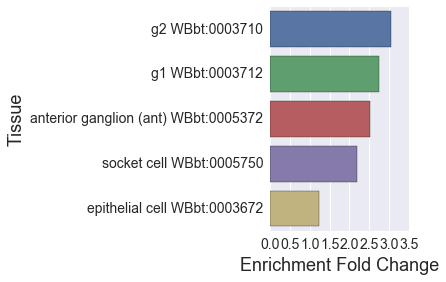

In [23]:
tea.plot_enrichment_results(df_res, title= 'Exercise', save= False)

Voila! We've analyzed our data! Yay! :D

If we wanted to save our plot, we would type:

In [ ]:
hgt.plot_enrichment_results(df_res, title= 'Exercise', save= True, dirGraphs= 'example_graph_dir/')
#This will save the graph in the corresponding directory. If no directory is specified, the graphs will be saved
#to the current working directory. 